In [2]:
%load_ext autoreload
%autoreload 2

from environment import ReversalEnvironment, train_test_split
from config import Conf

config = Conf()

train_layouts, test_layouts, all_layouts = train_test_split()
env = ReversalEnvironment(config, all_layouts)

num_trials = 40
inputs, targets, groundtruths = env.get_batch(num_trials, {'dropout': 1.0})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'dropout': 1.0}


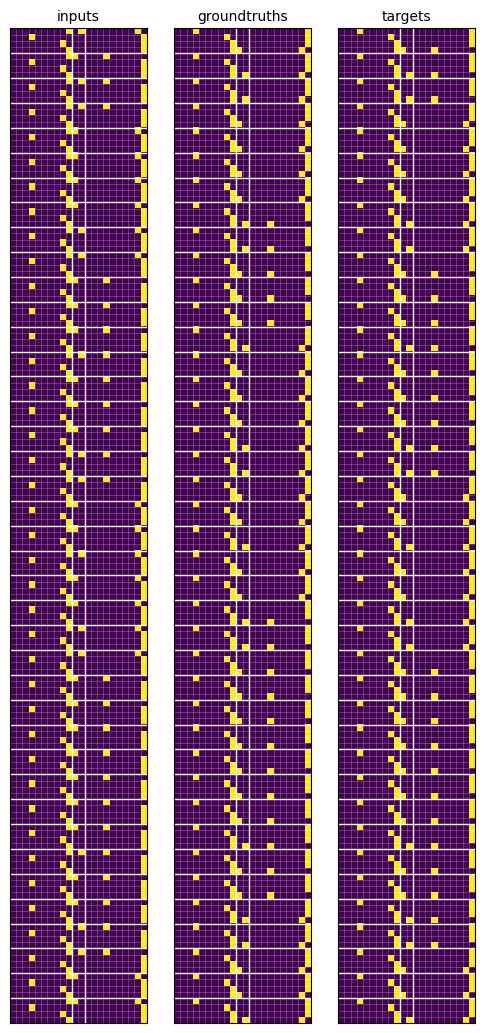

In [5]:
b = 2

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(6, num_trials))

def display_mat(ax, data, title=''):
    ax.imshow(data.numpy())
    ax.axvline(x=env.config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=env.config.r_dim + env.config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1,num_trials):
        ax.axhline(y=i * env.config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

display_mat(axes[0], inputs[b, :, :], title='inputs')
display_mat(axes[1], groundtruths[b, :, :], title='groundtruths')
display_mat(axes[2], targets[b, :, :], title='targets')

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from config import Conf
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def partition_trials(arr, t_axis=1):
    arr_trial = np.array_split(arr, arr.shape[t_axis]//Conf.trial_len, axis=t_axis)
    arr_trial = np.stack(arr_trial, axis=1)
    return arr_trial

def partition_all(arrs, t_axis=1):
    return [partition_trials(arr, t_axis=t_axis) for arr in arrs]

def argmax_all(arrs, onehot_axis=-1):
    return [np.argmax(arr, axis=onehot_axis) for arr in arrs]

def unpack_data_dict(data_dict):
    return data_dict['inputs'], data_dict['targets'], data_dict['choices'], data_dict['ground_truth'], data_dict['p_A_high'], data_dict['hidden']

def detect_anomalies(h, thresholds = Conf.threshold - 0.01):
    # thresholds = 4.99
    anomaly = h > thresholds
    return np.any(anomaly, axis=(1,2,3))

504, 1000, 5, 256
504, 256, n_p_bins, 5
3, 9, n_p_bins, 5


In [44]:
# Open the HDF5 file
load_dir = '../run_data_old_env/'

%load_ext autoreload
%autoreload 2

import h5py
from plotting import *

def list_all_datasets(h5file, prefix=''):
    print('here')
    print([k for k in h5file.keys()])
    for key in h5file.keys():
        item = h5file[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            # This is a dataset
            print(f"Dataset: {path}")
        elif isinstance(item, h5py.Group):
            # This is a group, recurse into it
            list_all_datasets(item, path)

with h5py.File(os.path.join(load_dir, 'data.h5'), 'r') as file:
    # Access the dataset
    list_all_datasets(file)
    print([k for k in file.keys()])

    # Determine chunk size
    chunk_size_trial = Conf.num_trials_test
    chunk_size_t = Conf.num_trials_test * Conf.trial_len
    # n_chunks = Conf.num_epochs_test  
    lens = []
    for key in file.keys():
        lens.append(file[key].shape[1])
    lens = np.unique(lens)
    n_chunks = np.min(lens) // chunk_size_trial

    # Read and process in chunks
    print(n_chunks)
    means, bin_counts = [], []
    for i in range(0, n_chunks):
        # Read a chunk
        data_dict = {}
        for key in file.keys():
            item = file[key]
            chunk_size = chunk_size_t if item.shape[1] == n_chunks * chunk_size_t else chunk_size_trial

            slices = [slice(None)] * len(item.shape)
            # Replace the slice in the specified axis with the new range
            start = i * chunk_size
            slices[1] = slice(start, start + chunk_size)
            slices = tuple(slices)
            data_dict[key] = item[slices]

        inputs, targets, choices, ground_truth, p_A, hiddens = unpack_data_dict(data_dict)
        
        inputs_trial, choices_trial, targets_trial, hidden_trial = partition_all([inputs, choices, targets, hiddens])
        print(inputs_trial.shape, choices_trial.shape, targets_trial.shape, hidden_trial.shape)

        inputs_arg_trial, choices_arg_trial, targets_arg_trial = argmax_all([inputs_trial, choices_trial, targets_trial])
        print(inputs_arg_trial.shape, choices_arg_trial.shape, targets_arg_trial.shape)

        # plot_trials(inputs, ground_truth, targets, choices, p_A, fname=f'panel_{i}_h5.png', trials=15, b=0)

        anomalous_batches = detect_anomalies(hidden_trial)
        # mean, bin_count = get_means(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, n_p_bins=50)
        # means.append(mean)
        # bin_counts.append(bin_count)
        # plot_average_layout_hists(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, neur_ids=[235])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
here
['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
Dataset: /choices
Dataset: /ground_truth
Dataset: /hidden
Dataset: /inputs
Dataset: /p_A_high
Dataset: /targets
['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
1
(504, 1000, 8, 21) (504, 1000, 8, 10) (504, 1000, 8, 10) (504, 1000, 8, 256)
(504, 1000, 8) (504, 1000, 8) (504, 1000, 8)


In [53]:
a = np.ones((3,4,5))
np.pad(a, ((1,0), (0,0), (0,0)))

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]])

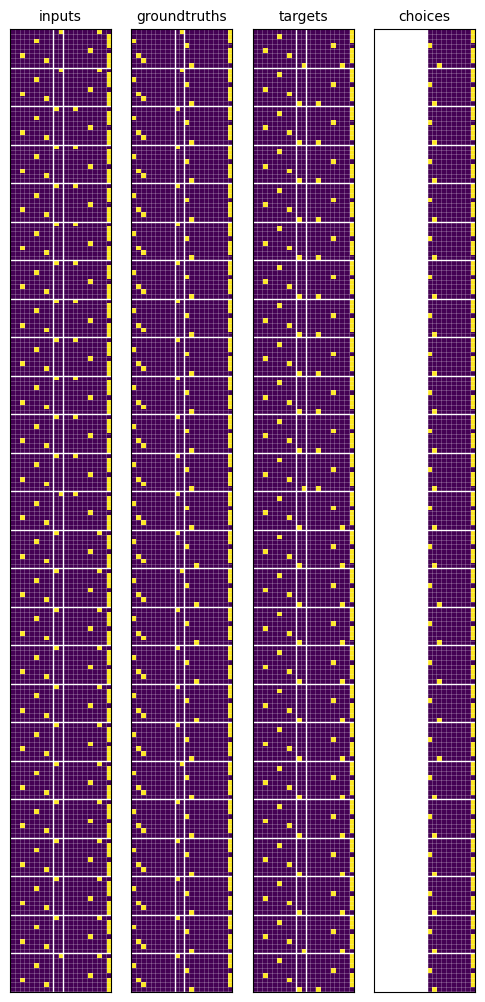

In [64]:
b = 0
t = 200

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(6, num_trials))

def pad_array(arr):
    if arr.shape[-1] == Conf.a_dim:
        return np.pad(arr, ((0,0), (Conf.x_dim + Conf.r_dim,0)), constant_values=np.nan)
    else:
        return arr
    
# q: how to set nan colour on matplotlib imshow?
# a:

def display_mat(ax, data, title=''):
    data = data.clone().numpy() if type(data) == torch.Tensor else data
    data = pad_array(data)
    ax.imshow(data)
    ax.axvline(x=env.config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=env.config.r_dim + env.config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1, t//Conf.trial_len + 1):
        ax.axhline(y=i * env.config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

display_mat(axes[0], inputs[b, :t, :], title='inputs')
display_mat(axes[1], ground_truth[b, :t, :], title='groundtruths')
display_mat(axes[2], targets[b, :t, :], title='targets')
display_mat(axes[3], choices[b, :t, :], title='choices')

In [89]:
# Open the HDF5 file
load_dir = '../run_data_new_env/'

%load_ext autoreload
%autoreload 2

import h5py
from plotting import *

def list_all_datasets(h5file, prefix=''):
    print('here')
    print([k for k in h5file.keys()])
    for key in h5file.keys():
        item = h5file[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            # This is a dataset
            print(f"Dataset: {path}")
        elif isinstance(item, h5py.Group):
            # This is a group, recurse into it
            list_all_datasets(item, path)

with h5py.File(os.path.join(load_dir, 'data.h5'), 'r') as file:
    # Access the dataset
    list_all_datasets(file)
    print([k for k in file.keys()])

    # Determine chunk size
    chunk_size_trial = Conf.num_trials_test
    chunk_size_t = Conf.num_trials_test * Conf.trial_len
    # n_chunks = Conf.num_epochs_test  
    lens = []
    for key in file.keys():
        print(key, file[key].shape)
        lens.append(file[key].shape[1])
    lens = np.unique(lens)
    # n_chunks = np.min(lens) // chunk_size_trial
    n_chunks = 1
    # Read and process in chunks
    print(n_chunks)
    means, bin_counts = [], []
    for i in range(0, n_chunks):
        # Read a chunk
        data_dict = {}
        for key in file.keys():
            item = file[key]
            chunk_size = chunk_size_t if item.shape[1] == n_chunks * chunk_size_t else chunk_size_trial

            slices = [slice(None)] * len(item.shape)
            # Replace the slice in the specified axis with the new range
            start = i * chunk_size
            slices[1] = slice(start, start + chunk_size)
            slices = tuple(slices)
            data_dict[key] = item[slices]

        inputs, targets, choices, ground_truth, p_A, hiddens = unpack_data_dict(data_dict)
        
        inputs_trial, choices_trial, targets_trial, hidden_trial = partition_all([inputs, choices, targets, hiddens])
        print(inputs_trial.shape, choices_trial.shape, targets_trial.shape, hidden_trial.shape)

        inputs_arg_trial, choices_arg_trial, targets_arg_trial = argmax_all([inputs_trial, choices_trial, targets_trial])
        print(inputs_arg_trial.shape, choices_arg_trial.shape, targets_arg_trial.shape)

        # plot_trials(inputs, ground_truth, targets, choices, p_A, fname=f'panel_{i}_h5.png', trials=15, b=0)

        anomalous_batches = detect_anomalies(hidden_trial)
        # mean, bin_count = get_means(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, n_p_bins=50)
        # means.append(mean)
        # bin_counts.append(bin_count)
        # plot_average_layout_hists(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, neur_ids=[235])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../run_data_new_env/data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [70]:
type(targets)

numpy.ndarray

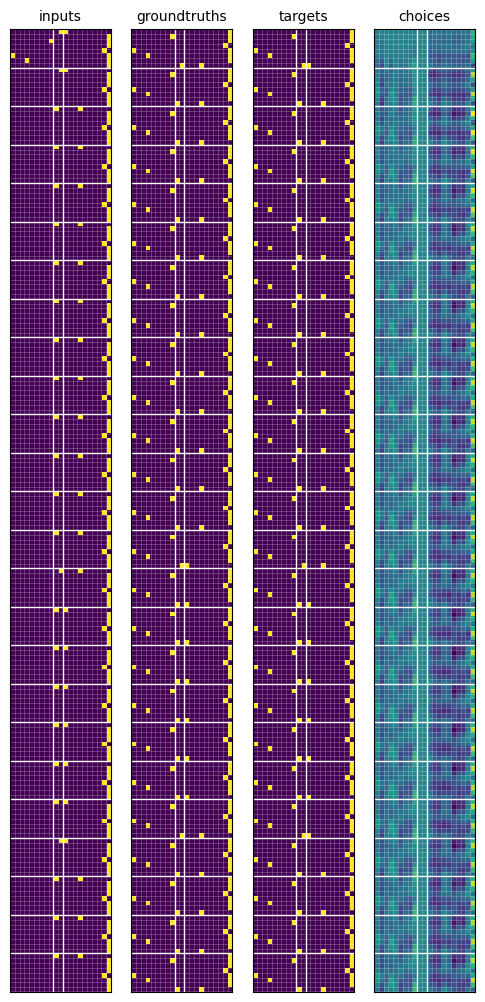

In [72]:
b = 0
t = 200

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(6, num_trials))

def display_mat(ax, data, title=''):
    data = data.clone().numpy() if type(data) == torch.Tensor else data
    ax.imshow(data)
    ax.axvline(x=env.config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=env.config.r_dim + env.config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1, t//Conf.trial_len + 1):
        ax.axhline(y=i * env.config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

display_mat(axes[0], inputs[b, :t, :], title='inputs')
display_mat(axes[1], ground_truth[b, :t, :], title='groundtruths')
display_mat(axes[2], targets[b, :t, :], title='targets')
display_mat(axes[3], choices[b, :t, :], title='choices')

100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 88.9


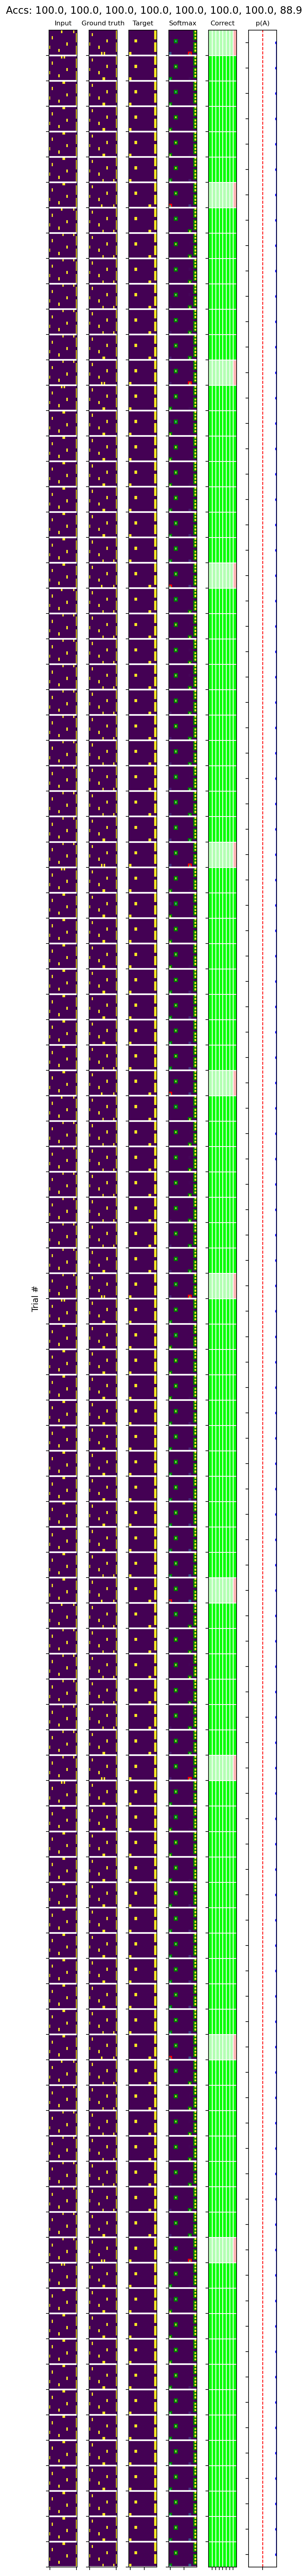

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jo/notebooks_paper/model/run_data_new/panel_0_h5.png'

In [40]:
plot_trials(inputs, ground_truth, targets[:,:,-Conf.a_dim:], choices[:,:,-Conf.a_dim:], np.ones((504,1000)), fname=f'panel_{i}_h5.png', trials=100, b=10)

In [12]:
%load_ext autoreload
%autoreload 2

from model.logger import LearningLogger
from environment import ReversalEnvironment, train_test_split
from model import SimpleRNN
from config import Conf

config = Conf()
logger = LearningLogger()
model = SimpleRNN(config)

train_layouts, test_layouts, _ = train_test_split()
env = ReversalEnvironment(config, layouts=train_layouts)
logger.add_pointer([model, env])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using thresholded RNN


In [14]:
logger.get_logs()

model {'hiddens': [], 'logits': []}
environment {'inputs': [], 'targets': [], 'groundtruths': [], 'p_A_high': []}


{'model': {'hiddens': [], 'logits': []},
 'environment': {'inputs': [],
  'targets': [],
  'groundtruths': [],
  'p_A_high': []}}

In [9]:
env.__class__.__module__

'environment'

In [16]:
a = {'a':2, 'b':3}
b = {**a, 'c':4}
print(b)

{'a': 2, 'b': 3, 'c': 4}


In [9]:
import torch

model = torch.nn.Linear(10, 10)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
s = torch.optim.lr_scheduler.LinearLR(opt, start_factor=1.0, end_factor=0.1, total_iters=10)

for i in range(20):
    print(s.get_last_lr())
    opt.step()
    s.step()

[0.01]
[0.0091]
[0.0082]
[0.007300000000000001]
[0.0064]
[0.0055000000000000005]
[0.004600000000000001]
[0.0037000000000000006]
[0.0028000000000000004]
[0.0019000000000000004]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
